<a href="https://colab.research.google.com/github/SherinJA/CloudVision-Automated-Cloud-Shape-Classification/blob/master/Cloud_classifier_multichannel_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Copy the ZIP file to Colab's temporary storage (faster extraction)
!cp "/content/cloud_dataset_3.zip" .

# Extract the ZIP file
!unzip -q cloud_dataset_3.zip -d cloud_dataset

# Verify extraction
!ls cloud_dataset  # Should show ['cumulus', 'cirrus', 'stratus']

cp: '/content/cloud_dataset_3.zip' and './cloud_dataset_3.zip' are the same file
cloud_dataset_3


Total images loaded: 2543


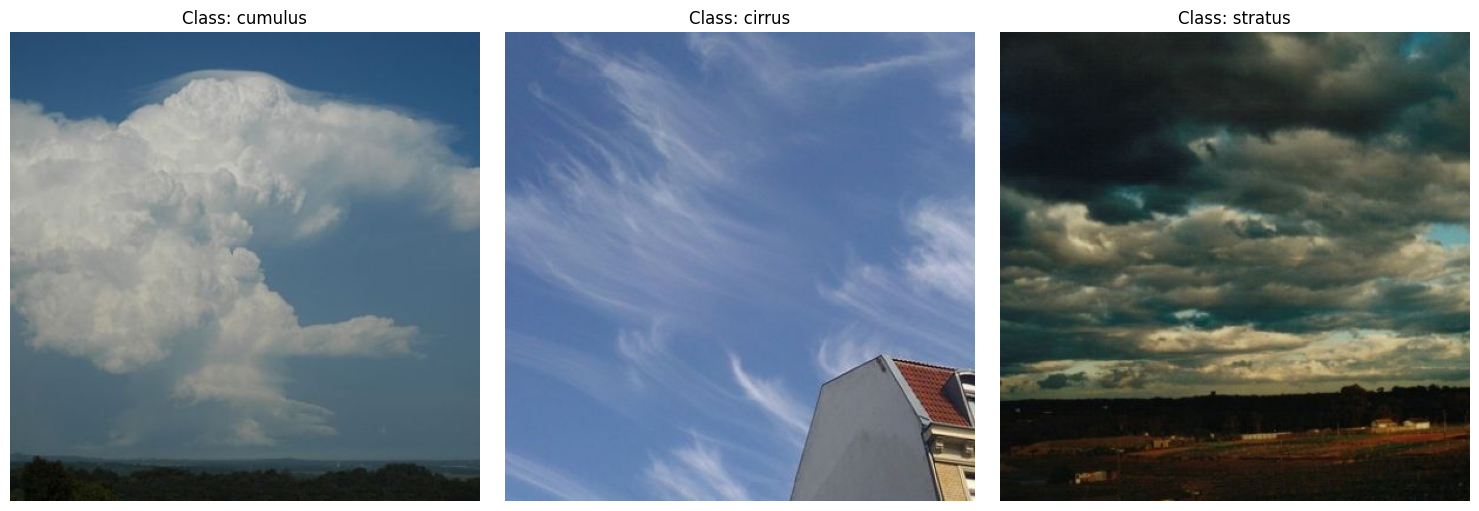

In [ ]:
class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['cumulus', 'cirrus', 'stratus']
        self.image_paths = []
        self.labels = []

        # Verify folder structure
        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.exists(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")

            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(idx)

        if len(self.image_paths) == 0:
            raise ValueError("No valid images found in the dataset folders")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Initialize dataset without transforms for verification
dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3")
print(f"Total images loaded: {len(dataset)}")

# Visualize sample images
plt.figure(figsize=(15, 5))
for i in range(3):  # Show one sample per class
    class_idx = i
    class_samples = [idx for idx, label in enumerate(dataset.labels) if label == class_idx]
    sample_idx = class_samples[0]
    image, label = dataset[sample_idx]

    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Epoch [1/20] | Train Loss: 1.0030 | Train Acc: 47.79% | Val Acc: 49.31% | LR: 1.00e-04
Epoch [2/20] | Train Loss: 0.8455 | Train Acc: 59.78% | Val Acc: 59.53% | LR: 1.00e-04
Epoch [3/20] | Train Loss: 0.7971 | Train Acc: 62.88% | Val Acc: 58.74% | LR: 1.00e-04
Epoch [4/20] | Train Loss: 0.7558 | Train Acc: 65.19% | Val Acc: 62.87% | LR: 1.00e-04
Epoch [5/20] | Train Loss: 0.7436 | Train Acc: 65.63% | Val Acc: 63.65% | LR: 1.00e-04
Epoch [6/20] | Train Loss: 0.6949 | Train Acc: 67.80% | Val Acc: 59.72% | LR: 1.00e-04
Epoch [7/20] | Train Loss: 0.6730 | Train Acc: 70.06% | Val Acc: 62.48% | LR: 1.00e-04
Early stopping at epoch 8
Epoch [8/20] | Train Loss: 0.6488 | Train Acc: 70.26% | Val Acc: 61.30% | LR: 5.00e-05
Epoch [9/20] | Train Loss: 0.6059 | Train Acc: 73.50% | Val Acc: 64.24% | LR: 5.00e-05
Epoch [10/20] | Train Loss: 0.6048 | Train Acc: 72.32% | Val Acc: 65.42% | LR: 5.00e-05
Epoch [11/20] | Train Loss: 0.5833 | Train Acc: 74.48% | Val Acc: 64.83% | LR: 5.00e-05
Epoch [12/20] |

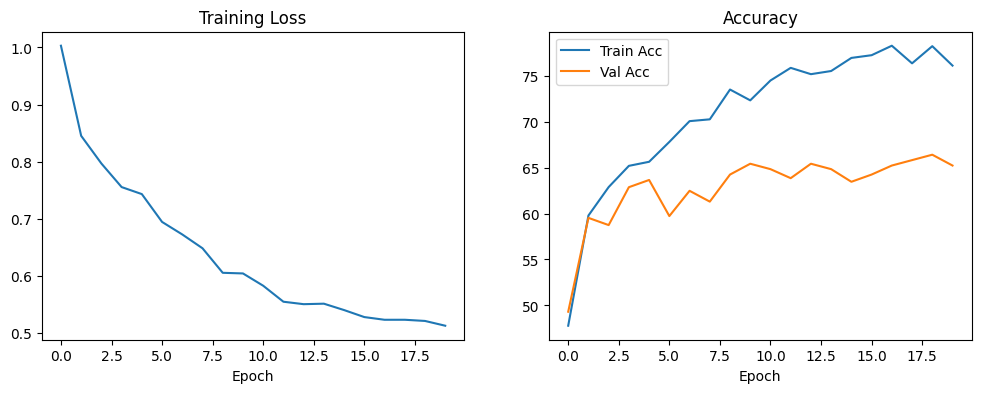

In [ ]:
#BEST CODE

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image



# ====================== 1. PREPROCESSING FUNCTIONS ======================
def clahe_enhance(image):
    """Enhances contrast using CLAHE"""
    image = np.array(image)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    enhanced = cv2.merge((l_clahe, a, b))
    return Image.fromarray(cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB))

class SkyAwareTransform:
    def __call__(self, image):
        img_array = np.array(image)
        blue_channel = img_array[:, :, 2]
        sky_mask = blue_channel > np.percentile(blue_channel, 70)
        # Instead of setting to 0, darken non-sky regions
        img_array[~sky_mask] = img_array[~sky_mask] // 2
        return Image.fromarray(img_array)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====================== ENHANCED DATA AUGMENTATION ======================
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: clahe_enhance(x)),  # Add CLAHE first
    SkyAwareTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(3,3)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ====================== MODEL DEFINITION ======================
class CloudModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)

        # Freeze initial layers
        for param in self.base_model.features[:5].parameters():
            param.requires_grad = False

        # Type-safe way to get in_features
        if isinstance(self.base_model.classifier, nn.Sequential):
            for layer in self.base_model.classifier:
                if isinstance(layer, nn.Linear):
                    num_features = layer.in_features
                    break
        else:
            num_features = 1280  # Default for efficientnet_b0

        # High dropout classifier
        # In your CloudModel class:
        num_features = self.base_model.classifier[1].in_features  # This works at runtime
        self.base_model.classifier = nn.Sequential(
        nn.Dropout(0.5),  # More reasonable dropout
        nn.Linear(num_features, 3))

    def forward(self, x):
        return self.base_model(x)

model = CloudModel().to(device)

# ====================== TRAINING SETUP ======================
# Loss function with class weighting (adjust as needed)
class_weights = torch.tensor([1.0, 1.2, 1.0]).to(device)  # Example weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with strong L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_acc = 0.0

    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.delta:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopping = EarlyStopping(patience=3, delta=0.005)

# ====================== TRAINING LOOP ======================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item() * images.size(0)
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * running_correct / total

        # Validation phase
        val_acc = evaluate(model, val_loader)

        # Update scheduler
        scheduler.step(val_acc)

        # Early stopping check
        if early_stopping(val_acc):
            print(f"Early stopping at epoch {epoch+1}")
            #break

        # Save best model
        if val_acc > max(history['val_acc'], default=0):
            torch.save(model.state_dict(), 'best_cloud_model.pth')

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    return history

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ====================== EXECUTION ======================
if __name__ == "__main__":

    # Create the full dataset with no transform initially
    # Create dataset with no transforms initially
    full_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=None)

    # Split into train/val FIRST
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

    # Create train and validation datasets with appropriate transforms
    train_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=train_transform)
    train_dataset.image_paths = [full_dataset.image_paths[i] for i in train_indices]
    train_dataset.labels = [full_dataset.labels[i] for i in train_indices]

    val_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=val_transform)
    val_dataset.image_paths = [full_dataset.image_paths[i] for i in val_indices]
    val_dataset.labels = [full_dataset.labels[i] for i in val_indices]

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

    # Plot results
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
# ====================== VISUALIZATION FUNCTIONS ======================
def visualize_preprocessing_pipeline(sample_image):
    """Shows each step of the preprocessing pipeline"""
    steps = [
        ("Original", sample_image),
        ("CLAHE Enhanced", clahe_enhance(sample_image)),
        ("Sky Aware Mask", SkyAwareTransform()(clahe_enhance(sample_image)))
    ]

    # Apply remaining transforms step-by-step
    temp_img = SkyAwareTransform()(clahe_enhance(sample_image))
    transforms_to_show = [
        ("Random Flip", transforms.RandomHorizontalFlip(p=1)(temp_img)),
        ("Color Jitter", transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2)(temp_img)),
        ("Gaussian Blur", transforms.GaussianBlur(kernel_size=(3,3))(temp_img))
    ]

    plt.figure(figsize=(18, 6))
    for i, (name, img) in enumerate(steps + transforms_to_show):
        plt.subplot(2, len(steps + transforms_to_show)//2 + 1, i+1)
        plt.imshow(img)
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, loader):
    """Generates and plots confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['cumulus', 'cirrus', 'stratus'],
                yticklabels=['cumulus', 'cirrus', 'stratus'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_test_predictions(model, loader, num_samples=5):
    """Shows test images with true and predicted labels"""
    model.eval()
    class_names = ['cumulus', 'cirrus', 'stratus']
    images_shown = 0

    plt.figure(figsize=(15, 8))
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                # Denormalize image
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                plt.subplot(1, num_samples, images_shown+1)
                plt.imshow(img)
                plt.title(f'True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}')
                plt.axis('off')
                images_shown += 1

            if images_shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()

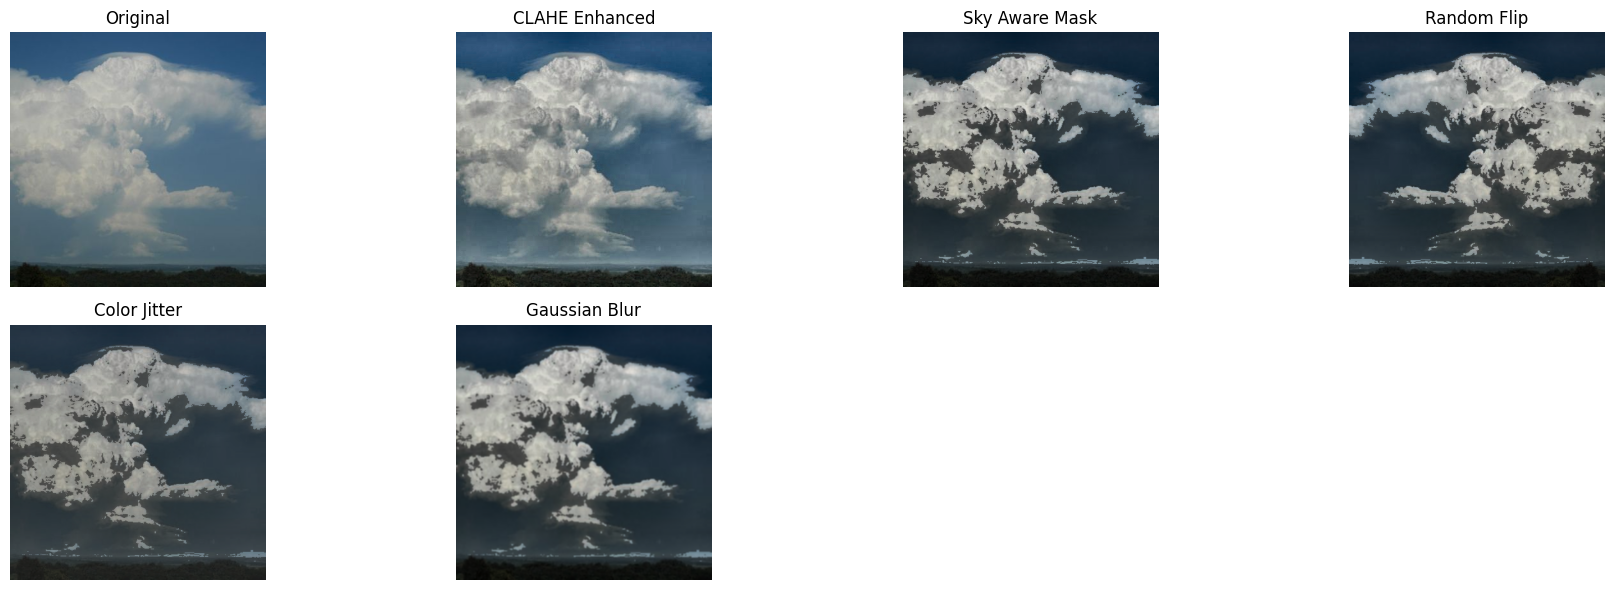

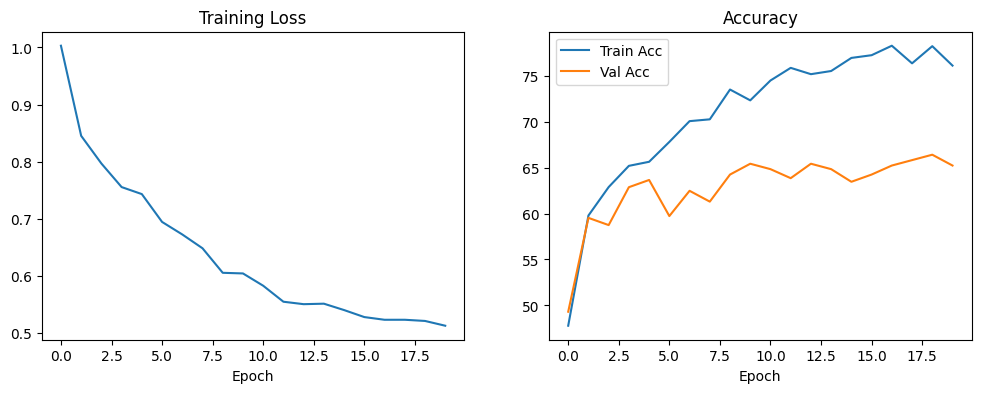

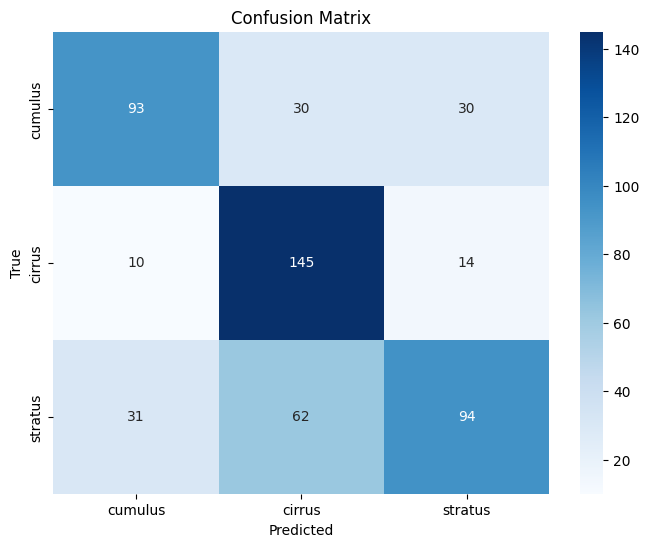

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


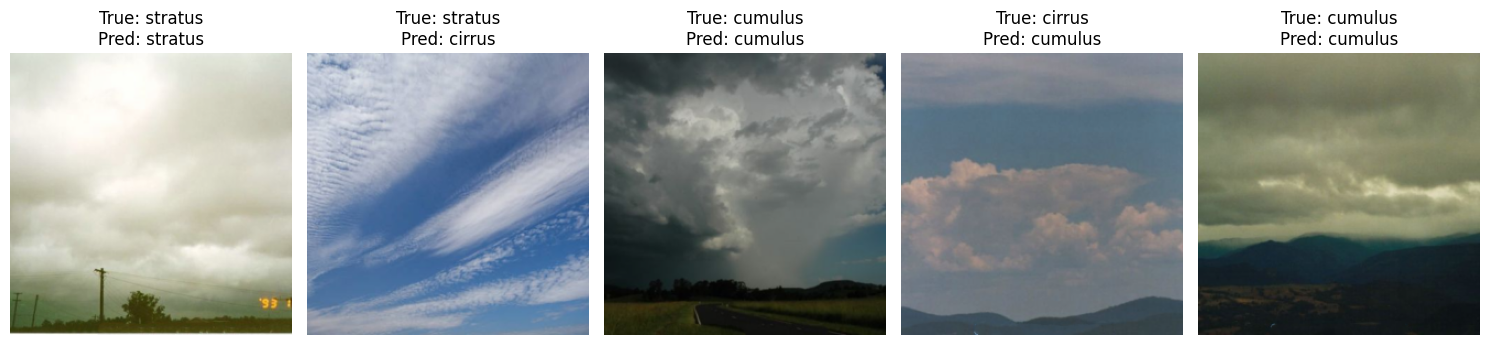

In [ ]:
# Visualize preprocessing steps
sample_image = Image.open(os.path.join("./cloud_dataset/cloud_dataset_3", "cumulus", os.listdir("./cloud_dataset/cloud_dataset_3/cumulus")[0]))
visualize_preprocessing_pipeline(sample_image)

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, val_loader)

# Visualize test predictions
visualize_test_predictions(model, val_loader, num_samples=5)

In [ ]:
#MULTI CHANNEL CNN
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim

# Extract dataset (unchanged)
!cp "/content/cloud_dataset_3.zip" .
!unzip -q cloud_dataset_3.zip -d cloud_dataset
!ls cloud_dataset  # Verify: ['cumulus', 'cirrus', 'stratus']

# ====================== 1. DATASET WITH MULTI-REGION SPLITTING ======================
class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['cumulus', 'cirrus', 'stratus']
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.exists(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(idx)

        if len(self.image_paths) == 0:
            raise ValueError("No valid images found in the dataset folders")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        width, height = image.size
        region_size = min(width, height) // 2
        regions = [
            image.crop((0, 0, region_size, region_size)),
            image.crop((width//2 - region_size//2, height//2 - region_size//2,
                        width//2 + region_size//2, height//2 + region_size//2)),
            image.crop((width - region_size, height - region_size, width, height))
        ]

        # Debug: Print region stats (optional, remove later)
        if idx == 0 and np.random.rand() < 0.1:  # Occasionally log
            for i, r in enumerate(regions):
                print(f"Region {i} mean: {np.array(r).mean():.2f}")

        if self.transform:
            regions = [self.transform(region) for region in regions]
        return regions, label

# ====================== 2. PREPROCESSING FUNCTIONS (UNCHANGED) ======================
def clahe_enhance(image):
    image = np.array(image)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    enhanced = cv2.merge((l_clahe, a, b))
    return Image.fromarray(cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB))

class SkyAwareTransform:
    def __call__(self, image):
        img_array = np.array(image)
        blue_channel = img_array[:, :, 2]
        sky_mask = blue_channel > np.percentile(blue_channel, 70)
        img_array[~sky_mask] = img_array[~sky_mask] // 2
        return Image.fromarray(img_array)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced transforms (adjusted for 128x128 regions, inspired by paper)
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: clahe_enhance(x)),
    SkyAwareTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.Resize((128, 128)),  # Match paper’s 128x128 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ====================== 3. MULTI-CHANNEL CNN MODEL ======================
class MultiChannelCloudModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Single shared backbone
        self.backbone = models.efficientnet_b0(pretrained=True)
        for param in self.backbone.features[:5].parameters():
            param.requires_grad = False
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()  # Remove original classifier

        # Feature reduction per channel
        self.channel_fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512)
        )

        # Fusion layer
        self.fusion_fc = nn.Sequential(
            nn.Linear(512 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(1024, 3)
        )

    def forward(self, regions):
        # Process each region through shared backbone
        feat1 = self.backbone(regions[0])
        feat2 = self.backbone(regions[1])
        feat3 = self.backbone(regions[2])

        # Reduce features
        feat1 = self.channel_fc(feat1)
        feat2 = self.channel_fc(feat2)
        feat3 = self.channel_fc(feat3)

        # Fuse and classify
        fused = torch.cat((feat1, feat2, feat3), dim=1)
        output = self.fusion_fc(fused)
        return output

model = MultiChannelCloudModel().to(device)

# ====================== 4. TRAINING SETUP (UNCHANGED) ======================
class_weights = torch.tensor([1.0, 1.2, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)  # Middle ground
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_acc = 0.0

    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.delta:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopping = EarlyStopping(patience=5, delta=0.01)  # More lenient

# ====================== 5. TRAINING LOOP (ADJUSTED FOR MULTI-INPUT) ======================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for regions, labels in train_loader:
            # Move all 3 regions and labels to device
            regions = [r.to(device) for r in regions]  # List of 3 tensors
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(regions)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item() * labels.size(0)
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * running_correct / total

        val_acc = evaluate(model, val_loader)
        scheduler.step(val_acc)

        if early_stopping(val_acc):
            print(f"Early stopping at epoch {epoch+1}")
            break

        if val_acc > max(history['val_acc'], default=0):
            torch.save(model.state_dict(), 'best_multi_channel_cloud_model.pth')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    return history

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for regions, labels in loader:
            regions = [r.to(device) for r in regions]
            labels = labels.to(device)
            outputs = model(regions)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ====================== 6. EXECUTION ======================
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    full_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=None)
    train_idx, val_idx = train_test_split(
        range(len(full_dataset)), test_size=0.2, stratify=full_dataset.labels, random_state=42
    )
    train_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=train_transform)
    train_dataset.image_paths = [full_dataset.image_paths[i] for i in train_idx]
    train_dataset.labels = [full_dataset.labels[i] for i in train_idx]

    val_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=val_transform)
    val_dataset.image_paths = [full_dataset.image_paths[i] for i in val_idx]
    val_dataset.labels = [full_dataset.labels[i] for i in val_idx]

    # DataLoader with collate_fn to handle list of regions
    def collate_fn(batch):
        regions, labels = zip(*batch)
        # Stack regions into batches for each channel
        return [torch.stack([r[i] for r in regions]) for i in range(3)], torch.tensor(labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, collate_fn=collate_fn)


    model = MultiChannelCloudModel().to(device)

    # Print model summary
    print("Model Summary (Backbone only, per region input shape: [3, 128, 128]):")
    summary(model.backbone, input_size=(3, 128, 128))  # Summarize backbone

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

    # Plot results (unchanged)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Note: Visualization functions (confusion matrix, predictions) need adjustment for multi-input.
# Add them as needed after testing the core functionality.

cp: '/content/cloud_dataset_3.zip' and './cloud_dataset_3.zip' are the same file
replace cloud_dataset/cloud_dataset_3/cumulus/Cb-N001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: cloud_dataset_3


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze

Model Summary (Backbone only, per region input shape: [3, 128, 128]):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-

KeyboardInterrupt: 

In [ ]:
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for regions, labels in loader:
            regions = [r.to(device) for r in regions]
            labels = labels.to(device)
            outputs = model(regions)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cumulus', 'Cirrus', 'Stratus'],
                yticklabels=['Cumulus', 'Cirrus', 'Stratus'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(all_labels, all_preds, target_names=['Cumulus', 'Cirrus', 'Stratus']))

plot_confusion_matrix(model, val_loader)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim

# Extract dataset (unchanged)
!cp "/content/cloud_dataset_3.zip" .
!unzip -q cloud_dataset_3.zip -d cloud_dataset
!ls cloud_dataset  # Verify: ['cumulus', 'cirrus', 'stratus']

# ====================== 1. DATASET WITH MULTI-REGION SPLITTING ======================
class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['cumulus', 'cirrus', 'stratus']
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.exists(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(idx)

        if len(self.image_paths) == 0:
            raise ValueError("No valid images found in the dataset folders")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Split image into 3 regions (assuming square input, adjust as needed)
        width, height = image.size
        region_size = min(width, height) // 2  # Adjust based on your image size
        regions = [
            image.crop((0, 0, region_size, region_size)),  # Top-left
            image.crop((width//2 - region_size//2, height//2 - region_size//2,
                        width//2 + region_size//2, height//2 + region_size//2)),  # Center
            image.crop((width - region_size, height - region_size, width, height))  # Bottom-right
        ]

        if self.transform:
            regions = [self.transform(region) for region in regions]

        return regions, label  # Return list of 3 regions and label

# ====================== 2. PREPROCESSING FUNCTIONS (UNCHANGED) ======================
def clahe_enhance(image):
    image = np.array(image)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    enhanced = cv2.merge((l_clahe, a, b))
    return Image.fromarray(cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB))

class SkyAwareTransform:
    def __call__(self, image):
        img_array = np.array(image)
        blue_channel = img_array[:, :, 2]
        sky_mask = blue_channel > np.percentile(blue_channel, 70)
        img_array[~sky_mask] = img_array[~sky_mask] // 2
        return Image.fromarray(img_array)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced transforms (adjusted for 128x128 regions, inspired by paper)
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: clahe_enhance(x)),
    SkyAwareTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.Resize((128, 128)),  # Match paper’s 128x128 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ====================== 3. MULTI-CHANNEL CNN MODEL ======================
class MultiChannelCloudModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Three EfficientNet-B0 branches
        self.channel1 = models.efficientnet_b0(pretrained=True)
        self.channel2 = models.efficientnet_b0(pretrained=True)
        self.channel3 = models.efficientnet_b0(pretrained=True)

        # Freeze initial layers for all channels
        for channel in [self.channel1, self.channel2, self.channel3]:
            for param in channel.features[:5].parameters():
                param.requires_grad = False

        # Get feature dimension from EfficientNet-B0
        num_features = self.channel1.classifier[1].in_features  # 1280 for B0

        # Replace classifiers with feature extractors
        for channel in [self.channel1, self.channel2, self.channel3]:
            channel.classifier = nn.Sequential(
                nn.Dropout(0.4),  # Adjusted from 0.5
                nn.Linear(num_features, 512)  # Reduce to 512 as in paper
            )

        # Fusion layer (inspired by paper’s weighted fusion)
        self.fusion_fc = nn.Sequential(
            nn.Linear(512 * 3, 1024),  # Concatenate 3x512 features
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 3)  # Output 3 classes
        )

    def forward(self, regions):
        # Extract features from each region
        feat1 = self.channel1(regions[0])
        feat2 = self.channel2(regions[1])
        feat3 = self.channel3(regions[2])

        # Concatenate features
        fused = torch.cat((feat1, feat2, feat3), dim=1)  # Shape: [batch_size, 512*3]

        # Final classification
        output = self.fusion_fc(fused)
        return output

model = MultiChannelCloudModel().to(device)

# ====================== 4. TRAINING SETUP (UNCHANGED) ======================
class_weights = torch.tensor([1.0, 1.2, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)  # Reduced weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_acc = 0.0

    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.delta:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopping = EarlyStopping(patience=3, delta=0.005)

# ====================== 5. TRAINING LOOP (ADJUSTED FOR MULTI-INPUT) ======================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for regions, labels in train_loader:
            # Move all 3 regions and labels to device
            regions = [r.to(device) for r in regions]  # List of 3 tensors
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(regions)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item() * labels.size(0)
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * running_correct / total

        val_acc = evaluate(model, val_loader)
        scheduler.step(val_acc)

        if early_stopping(val_acc):
            print(f"Early stopping at epoch {epoch+1}")
            break

        if val_acc > max(history['val_acc'], default=0):
            torch.save(model.state_dict(), 'best_multi_channel_cloud_model.pth')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    return history

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for regions, labels in loader:
            regions = [r.to(device) for r in regions]
            labels = labels.to(device)
            outputs = model(regions)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ====================== 6. EXECUTION ======================
if __name__ == "__main__":
    # Dataset splitting
    full_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=None)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

    train_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=train_transform)
    train_dataset.image_paths = [full_dataset.image_paths[i] for i in train_indices]
    train_dataset.labels = [full_dataset.labels[i] for i in train_indices]

    val_dataset = CloudDataset(root_dir="./cloud_dataset/cloud_dataset_3", transform=val_transform)
    val_dataset.image_paths = [full_dataset.image_paths[i] for i in val_indices]
    val_dataset.labels = [full_dataset.labels[i] for i in val_indices]

    # DataLoader with collate_fn to handle list of regions
    def collate_fn(batch):
        regions, labels = zip(*batch)
        # Stack regions into batches for each channel
        return [torch.stack([r[i] for r in regions]) for i in range(3)], torch.tensor(labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, collate_fn=collate_fn)

    model = MultiChannelCloudModel().to(device)

    # Print model summary
    print("Model Summary (Backbone only, per region input shape: [3, 128, 128]):")
    summary(model.channel1, input_size=(3, 128, 128))  # Summarize backbone

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

    # Plot results (unchanged)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Note: Visualization functions (confusion matrix, predictions) need adjustment for multi-input.
# Add them as needed after testing the core functionality.

cp: '/content/cloud_dataset_3.zip' and './cloud_dataset_3.zip' are the same file
replace cloud_dataset/cloud_dataset_3/cumulus/Cb-N001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: cloud_dataset_3


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze

Model Summary (Backbone only, per region input shape: [3, 128, 128]):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-